In [212]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy
import networkx as nx


# Generating data

In [213]:
n,k = 2500,2
X = numpy.random.uniform(low=-100,high=100,size=(n,k))

In [214]:
y=(X[:,0]**2 + X[:,1]**2)**.5 < 60

In [215]:
X,X_test,y,y_test = train_test_split(X,y)

In [216]:
X.shape,X_test.shape

((1875, 2), (625, 2))

In [217]:
def PlotData(X,y):
    plt.scatter(x=X[:,0],y=X[:,1],c=y)    

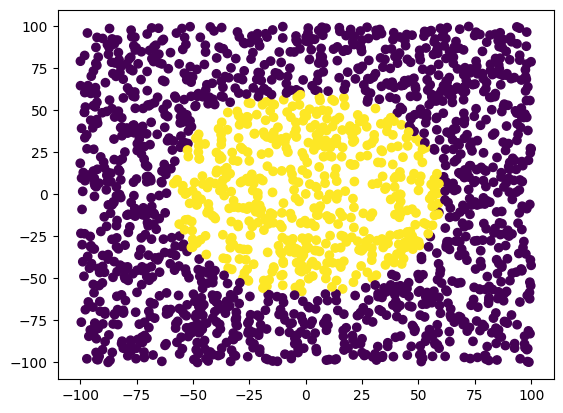

In [218]:
PlotData(X,y)

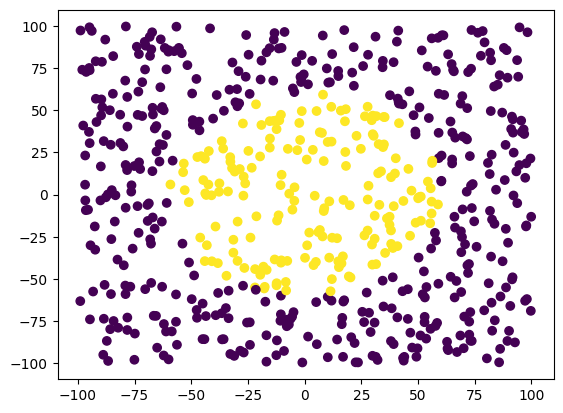

In [219]:
PlotData(X_test,y_test)

# Network Architechture
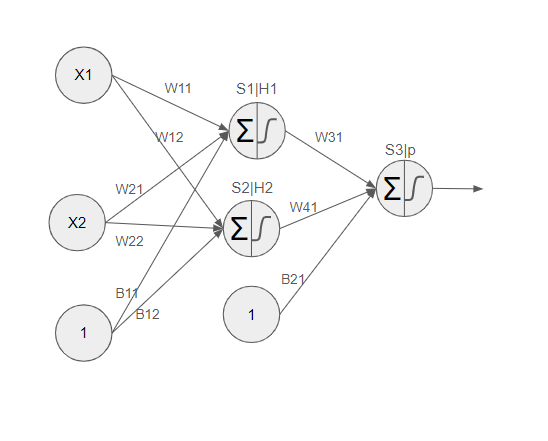

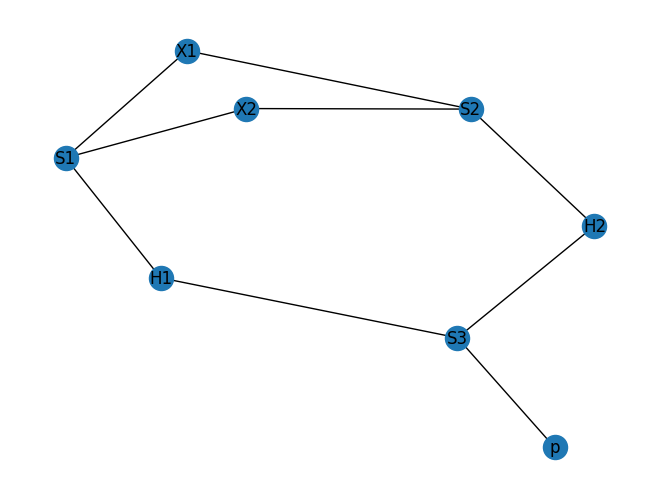

In [220]:
graph = {
    'S1':['X1','X2'],
    'S2':['X1','X2'],
    'H1':['S1'],
    'H2':['S2'],
    'S3':['H1','H2'],
    'p':['S3']
    
}
G = nx.Graph(graph)
nx.draw(G,with_labels=True)

In [373]:
ModelGraph = nx.Graph()

class GraphManager:
    def __init__(self):
        ...
    def add_to_graph(self,val):
        inids,out = val
        outid = id(out)
        if not hasattr(inids,'__iter__'):
            inids = [inids]
        for inid in inids :
            ModelGraph.add_edges_from([(inid,outid)])
        return outid,out
    def draw():
        nx.draw(ModelGraph,with_labels=True)    


class Σ(GraphManager):
    def __init__(self,In=None):
        super().__init__()
        self.In = In
    def eval(self):
        if not hasattr(self,'w'):
            self.w = numpy.zeros((self.In[1].shape[1]+1,1))
            self.b = numpy.ones((self.In[1].shape[0],1))
        out = lambda : numpy.c_[self.In[1],self.b].dot(self.w)
        self.outid,self.out = self.add_to_graph((self.In[0],out())) 
        return (self.outid,self.out)
    def prime(self):
        self.pr = numpy.c_[self.In,self.b].sum(axis=0).reshape(-1,1)
        return self.pr
    def update(self,Δnext):
        self.Δ = self.prime()*Δnext
        self.w -= self.Δ
        return self.Δ

In [374]:
class σ(GraphManager):
    def __init__(self,In=None):
        super().__init__()
        self.In = In
    def eval(self):
        out = lambda: 1/(1+numpy.exp(-self.In[1]))
        self.outid,self.out = self.add_to_graph((self.In[0],out())) 
        return (self.outid,self.out)
    def prime(self):
        self.p = (self.out*(1-self.out)).sum()
        return self.p
    def update(self,Δnext):
        self.Δ = Δnext*self.prime()
        return self.Δ    

In [375]:
s = Σ(In=(id(X),X))
s.eval()

(139752941443888,
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]))

In [376]:
z = σ(s.eval())
z.eval()

(139752941441872,
 array([[0.5],
        [0.5],
        [0.5],
        ...,
        [0.5],
        [0.5],
        [0.5]]))

In [370]:
z.prime()

468.75

In [371]:
z.update(10)

4687.5

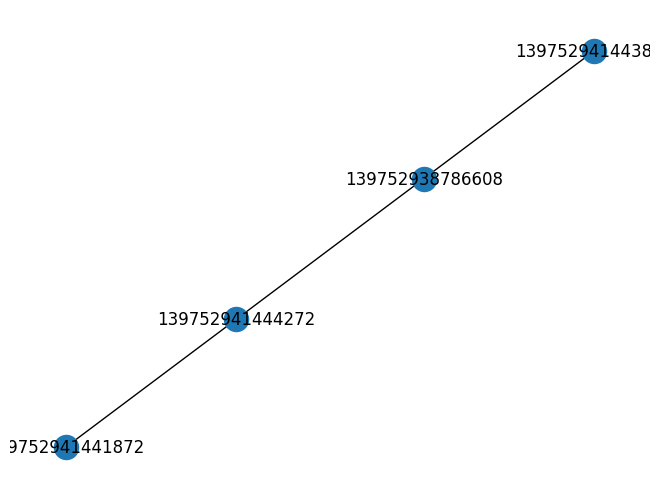

In [377]:
GraphManager.draw()

In [382]:
class fullyconnected(GraphManager):
    def __init__(self,n_out,In=None):
        super().__init__()
        self.n_out = n_out
        self.__In = [Σ((id(In),In))]*self.n_out
    @property
    def In(self):
        return self.__In
    @In.setter
    def In(self,v):
        v = dict(v)
        for s in self.__In:
            s.In = (v.keys(),numpy.concatenate(v.values(),axis=1))
    def __len__(self):
        return len(self.In)
    def eval(self):
        self.out = [s.eval() for s in self.In]
        return self.out
    def update(self,Δnext):
        self.Δ = [ v.update(Δnext[ix]) for ix,v in enumerate(self.In) ]
        return self.Δ    
class activation(GraphManager):
    def __init__(self,func=σ):
        super().__init__()
        self.func = func
    @property
    def In(self):
        return self.__In
    @In.setter
    def In(self,v):
        self.__In = [self.func(s) for s in v]
    def __len__(self):
        return len(self.In)
    def eval(self):
        self.out = [act.eval() for act in self.In]
        return self.out
    def update(self,Δnext) :
        self.Δ = [ act.update(Δnext) for act in self.In ]
        return self.Δ        

# Backpropagation

## Sequential architecture

In [383]:
class Sequential:
    def __init__(self,steps):
        self.steps = steps
    def eval(self):
        self.out  = self.steps[0].eval()
        for step in self.steps[1:]:
            step.In = self.out
            step.eval()
            self.out = step.out
        return self.out
    def update(self,Δnext):
        self.Δnext = Δnext
        for step in self.steps[::-1]:
            self.Δnext = step.update(self.Δnext)
        return self

## Cost function

In [384]:
class binaryCrossEntropy:
    def __init__(self,y,p):
        self.y = y
        self.p = p.clip(1e-8)#for safety to avoid zero division error
    def eval(self):
        self.out = -(self.y*numpy.log(self.p) + (1-self.y)*numpy.log(1-self.p)).mean()
        return self.out
    def prime(self):
        self. pr = -(self.y/self.p - (1-self.y)/(1-self.p)).mean()
        return self.pr

# Model Architecture

In [386]:
ModelGraph = nx.Graph()

Model = Sequential([

        fullyconnected(n_out=3,In=(X-X.mean())/X.std()),
])
Model.eval()

[(139752940747920,
  array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]])),
 (139752940736976,
  array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]])),
 (139752940744080,
  array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]))]

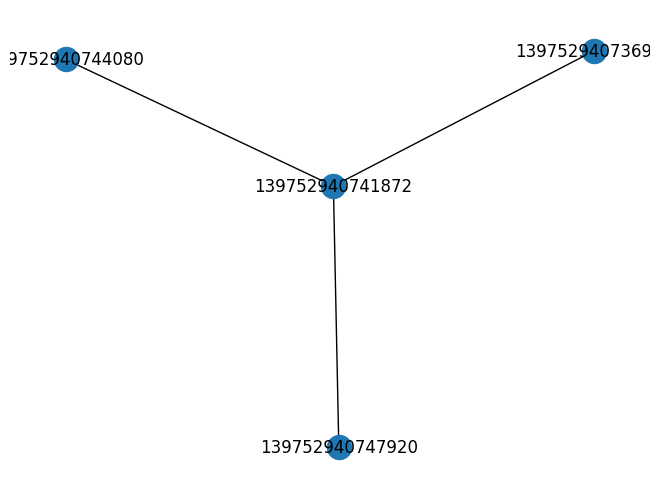

In [387]:
GraphManager.draw()

In [407]:
ModelGraph = nx.Graph()

Model = Sequential([

        fullyconnected(n_out=5,In=(X-X.mean())/X.std()),
        activation()
])
Model.eval()

[(139752596964240,
  array([[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]])),
 (139752597083056,
  array([[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]])),
 (139752597083152,
  array([[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]])),
 (139752597084304,
  array([[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]])),
 (139752597080944,
  array([[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]]))]

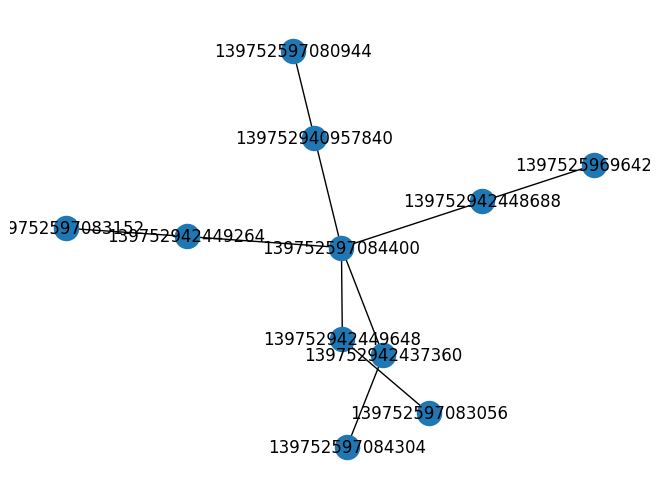

In [408]:
GraphManager.draw()

In [ ]:
ModelGraph = nx.Graph()

Model = Sequential([

        fullyconnected(n_out=5,In=(X-X.mean())/X.std()),
        activation()
])
Model.eval()

In [293]:
n_epochs = 30
α = 1e-3

for n in range(n_epochs):
    print(n)
    C = binaryCrossEntropy(y,Model.eval()[0]) 
    print('n=',n,'logloss=',C.eval())
    Model = Model.update(α*C.prime())

0
n= 0 logloss= 0.6931471805599468
1
n= 1 logloss= 0.6755077872730407
2
n= 2 logloss= 0.660830294901597
3
n= 3 logloss= 0.6486089540132396
4
n= 4 logloss= 0.6384215840039045
5
n= 5 logloss= 0.6299179309863967
6
n= 6 logloss= 0.6228085639204252
7
n= 7 logloss= 0.6168548592146923
8
n= 8 logloss= 0.6118602823877856
9
n= 9 logloss= 0.6076629756510343
10
n= 10 logloss= 0.6041295553755642
11
n= 11 logloss= 0.6011499774787626
12
n= 12 logloss= 0.5986333170595224
13
n= 13 logloss= 0.5965043151687481
14
n= 14 logloss= 0.5947005607014918
15
n= 15 logloss= 0.5931701934420212
16
n= 16 logloss= 0.5918700322705174
17
n= 17 logloss= 0.5907640489866667
18
n= 18 logloss= 0.5898221225444942
19
n= 19 logloss= 0.5890190206276763
20
n= 20 logloss= 0.5883335655672508
21
n= 21 logloss= 0.5877479498580018
22
n= 22 logloss= 0.5872471732363733
23
n= 23 logloss= 0.586818578701557
24
n= 24 logloss= 0.5864514692244921
25
n= 25 logloss= 0.586136790395828
26
n= 26 logloss= 0.5858668670794724
27
n= 27 logloss= 0.5856

In [298]:
Model.eval()[0]

array([[0.28932895],
       [0.29224296],
       [0.28941271],
       ...,
       [0.28841984],
       [0.28676317],
       [0.29056445]])

In [196]:
Model.eval()[0]

array([[0.28045534],
       [0.28045534],
       [0.28045534],
       ...,
       [0.28045534],
       [0.28045534],
       [0.28045534]])

In [189]:
z[0].std()

0.6649073371607864

In [158]:
z[0].min(),z[0].max()

(-2.1030761142916026, 0.32154933789191475)